## Import and Setup

In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [229]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [230]:
pd.options.display.float_format = '{:.5f}'.format

## Util Functions

In [231]:
def read_data(file_path):
    
    #Read the parquet files
    df = pd.read_parquet(file_path)
    
    #Create the duration column
    df["duration"] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda time_delta: time_delta.total_seconds()/60)
    df = df.rename(columns={"duration":"duration_minute"})
    
    #Filter out the outliers
    filtered_df = df[(df.duration_minute >= 1)&(df.duration_minute <= 60)]
    
    return filtered_df

In [232]:
def preprocess_data(df):
    
    #replace the Null values with -1
    df = df.fillna(value={"PUlocationID": -1, "DOlocationID": -1})
    
    #Cast the categorical columns as string
    features_df = df[["PUlocationID", "DOlocationID"]].astype(str)
    
    return features_df

## Data Preparation

### Train Dataset

In [233]:
train_filepath = "../data/fhv_tripdata_2021-01.parquet"
train_df = read_data(train_filepath)
train_df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration_minute
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.00000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.00000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.00000,None,B00037,8.28333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.00000,None,B00037,15.21667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.00000,None,B00037,9.05000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.00000,7.00000,None,B03266,8.75000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.00000,91.00000,None,,57.60000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.00000,171.00000,None,B03285,16.20000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.00000,15.00000,None,B03285,19.43333


In [234]:
features_df = preprocess_data(train_df)
features_df

,PUlocationID,DOlocationID
0,-1.0,-1.0
1,-1.0,-1.0
3,-1.0,72.0
4,-1.0,61.0
5,-1.0,71.0
...,...,...
1154107,7.0,7.0
1154108,44.0,91.0
1154109,171.0,171.0
1154110,15.0,15.0


In [235]:
train_dict = features_df.to_dict(orient='records')
dv = DictVectorizer() #dictionary vectorizer for one hot encodding
X_train = dv.fit_transform(train_dict)

y_train = filtered_df.duration_minute.values
X_train.shape, y_train.shape

((1109826, 525), (1109826,))

### Validation Dataset

In [236]:
validation_df = read_data("../data/fhv_tripdata_2021-02.parquet")
val_features_df = pre_process_data(validation_df)
val_features_df

,PUlocationID,DOlocationID
1,173.0,82.0
2,173.0,56.0
3,82.0,129.0
4,-1.0,225.0
5,-1.0,61.0
...,...,...
1037687,-1.0,31.0
1037688,-1.0,169.0
1037689,28.0,171.0
1037690,16.0,252.0


In [237]:
val_dict = val_features_df.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_val = validation_df.duration_minute.values
X_val.shape, y_val.shape

((990113, 525), (990113,))

## Model Training and Validation

### Model training

In [238]:
linear_regression_model = LinearRegression()

In [239]:
linear_regression_model.fit(X_train, y_train)

LinearRegression()

### Evaluation on train data

In [245]:
y_pred_train = linear_regression_model.predict(X_train)
mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False)

10.528519425310185

### Model validation

In [246]:
y_pred = linear_regression_model.predict(X_val)

C:\Users\SESA607807\Anaconda3\envs\mlopszoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SESA607807\Anaconda3\envs\mlopszoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


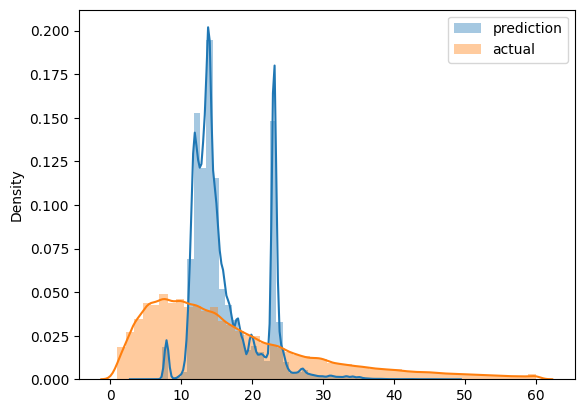

In [247]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_val, label="actual")
plt.legend()

In [248]:
mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

11.014285828610237

## Saving Model

In [249]:
with open("../models/linear_regression.bin", "wb") as f_out:
    pickle.dump((dv, linear_regression_model), f_out)